<a href="https://colab.research.google.com/github/kento-koyama/bayesian_predictive_micro_ICPMF12/blob/main/Workshop_(inactivation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modelling
##Load libraries.  
pystan: Bayesian MCMC  
pandas: Data manipulation  
numpy: Data calculation  
seaborn: Visualization  
matplotlib.pyplot: Visualization  
pickles: Object saving/loading  
arviz: Visualization of pystan  

In [ ]:
!pip install -Uqq pystan==2.19.1.1
import pystan 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import math
from sklearn.metrics import mean_squared_error
plt.rcParams['font.sans-serif'] = ['Arial'] 

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/base_command.py", line 167, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/commands/install.py", line 339, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.9/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 94, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 481, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.9/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 348, in resolve
    self._add_to_criteria(self.state.criteria, r, parent=None)

ModuleNotFoundError: ignored

#Data reading and preperation

The data imported from reported article through github: Hiura, S., Abe, H., Koyama, K. & Koseki, S. Bayesian generalized linear model for simulating bacterial inactivation/growth considering variability and uncertainty. Front. Microbiol. 12, 674364 (2021).

In [ ]:
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')
TIME = data['TIME']
Nt = data['Nt']
Initial = data['Initial']

#Model construction
stan_code includea the script for stan (C language).
stan scropt is constructed by several sections.

##data section
Define the data shape
##parameters section
Define the parameters and parameter shape
##model section
Define the following prior distribution

In [ ]:
#parameter estimation
#compile

stan_code = """
  data {
    int M;
	  int<lower=0> Nt[M];
	  real TIME[M];
	  int Initial[M];
  }

  parameters {
	  real<lower=0> a;
	  real<lower=0> b;  
	  real<lower=0> n0;
  }

  model {
	  for (m in 1:M) {
		  if (Initial[m] != 0 ) {
			  Nt[Initial[m]] ~ poisson(n0);
		  }
	  }
    for (m in 1:M) {        
        Nt[m] ~ binomial(n0,10^(-((TIME[m]/a)^b)));
    }
  }

"""

model = pystan.StanModel(model_code=stan_code)

In [ ]:
stan_data = data.to_dict('list')
stan_data.update({'M':len(data)})

In [ ]:
#MCMC sampling
fit_nuts = model.sampling(data = stan_data,iter=10000,chains=4,warmup=5000)

In [ ]:
scale = fit_nuts['a'] #scale parameter(δ)
shape = fit_nuts['b'] #shape parameter(p)

In [ ]:
#correlation
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('on')
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.text(.5, .5, 'Corr:\n{:.2f}'.format(r),color=txtcolor, fontsize=28, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:181: UserWarning: The label '_nolegend_' of <matplotlib.patches.Patch object at 0x7f6f0132a490> starts with '_'. It is thus excluded from the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


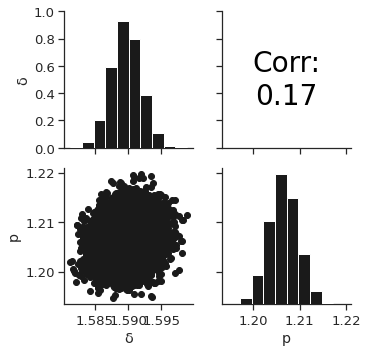

In [ ]:
#pairplot
sns.set(style='ticks', font_scale=1.2)
d = pd.DataFrame({'δ':scale,'p':shape},columns=['δ', 'p'])
g = sns.PairGrid(d)
g = g.map_diag(plt.hist,color='k')
g = g.map_lower(plt.scatter,color='k')
g = g.map_upper(corrfunc)
g = g.add_legend()

In [ ]:
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/frequentism_fitting.csv"
data = pd.read_csv(url, encoding='utf-8')

t = data['TIME']
R = data['Ratio']

#fitting
parameter_initial = np.array([1.4,1.4])
def func(t, α, β):
    return -((t/α)**β)
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, R, p0=parameter_initial)
y = func(t, parameter_optimal[0], parameter_optimal[1])
print("scale parameter (α) =", format(parameter_optimal[0]))
print("shape parameter (β) =", format(parameter_optimal[1]))
RMSE = np.sqrt(mean_squared_error(R,y))
print("RMSE= ", format(RMSE))

#result of fitting
T = np.arange(0,6,0.05)
y = 4.9-((T/parameter_optimal[0])**parameter_optimal[1])


scale parameter (α) = 1.5848891703833252
shape parameter (β) = 1.2615817915254068
RMSE=  0.17570346625247327


In [ ]:
#fitting by bayesian 
scale = fit_nuts['a'] #scale parameter(δ)
shape = fit_nuts['b'] #shape parameter(p)
N0 = 79000 #initial cell number

#time
T0 =[]
for n in range(61):
    t0 = n*0.1
    T0.append(t0)
T1 = pd.DataFrame(T0)

#confidence interval
y_conf_int = np.zeros((len(scale),len(T0)))
for i in range(len(scale)):
    for j in range(len(T0)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T0[j])/scale[i])**(shape[i]))))
y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

#predicted interval
y_pred_int = np.zeros((len(scale),len(T0)))
for i in range(len(scale)): 
    for j in range(len(T0)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T0[j])/scale[i])**(shape[i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


<ipython-input-10-c0b2c45a5d75>:34: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

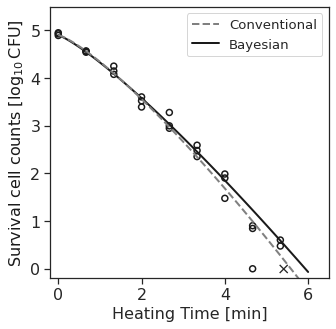

In [ ]:
#graph
#plot+frequentism+bayes
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/bayesian_fitting.csv"
data2 = pd.read_csv(url, encoding='utf-8')
x = data2['TIME']
y1 = data2['Nt']
y1 = np.log10(y1)
fig = plt.figure()
plt.figure(figsize=(5,5))
sns.set_style(style='ticks')
plt.xlabel("Heating Time [min]", size=16)
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')    
plt.xticks([0,2,4,6])
plt.xlim(-0.2,6.5)
plt.ylim(-0.2,5.5)
plt.plot(T, y, color="gray", linestyle='dashed', lw=2, zorder=2, label='Conventional')     
plt.text(5.25, -0.1, '×', fontsize=16)
plt.plot(T0,y_conf_500, linestyle = 'solid', zorder=1, color='k', lw=2.0, label='Bayesian')
plt.scatter(x, y1, facecolors='None', edgecolors='k',linewidths=1.5) 
plt.legend()
plt.show()

In [ ]:

# data import
url = "https://raw.githubusercontent.com/Satoko-Hiura/Bayesian-generalized-linear-model-for-simulating-bacterial-inactivation-growth/main/code/inactivation/data/850cell.csv"
data = pd.read_csv(url, encoding='utf-8')
time = data['TIME']
N = data['N']

In [ ]:
#prepare for prediction
#time 
T =[]
for n in range(121):
    t0 = n*0.05
    T.append(t0)

In [ ]:

#prediction
N0 = 850 #initial cell number

y_pred_int = np.zeros((len(scale),len(T)))
for i in range(len(scale)): 
    for j in range(len(T)):    
        y_pred_int[i,j] = np.random.poisson(N0*(10**(-((np.array(T[j])/scale[i])**(shape[i])))))
y_pred_int_975 = np.percentile(y_pred_int, 2.5, axis=0)
y_pred_int_025 = np.percentile(y_pred_int, 97.5, axis=0)
y_pred_int_500 = np.percentile(y_pred_int, 50.0, axis=0)
y_pred = np.log10(y_pred_int)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)

<ipython-input-14-3d089093fd60>:11: RuntimeWarning: divide by zero encountered in log10
  y_pred = np.log10(y_pred_int)
/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [ ]:

#confidence interval
y_conf_int = np.zeros((len(scale),len(T)))
for i in range(len(scale)):
    for j in range(len(T)):
        y_conf_int[i,j] = N0*(10**(-((np.array(T[j])/scale[i])**(shape[i]))))

y_conf_int_975 = np.percentile(y_conf_int, 2.5, axis=0)
y_conf_int_025 = np.percentile(y_conf_int, 97.5, axis=0)
y_conf_int_500 = np.percentile(y_conf_int, 50.0, axis=0)
y_conf = np.log10(y_conf_int)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)

In [ ]:
#accuracy
Time = [3.0,3.3,3.6,4.0,4.3,4.6]
k=[0,1,2,3,4,5]
evaluation =[]
for t,k in zip(Time,k):
    T1 = int(t*20)
    y_pred_min = y_pred_int_975[T1]
    y_pred_max = y_pred_int_025[T1]
    hani =[]
    for l in range(60):
        number = 60*k + l
        N_target = N[number]
        if y_pred_min <= N_target <= y_pred_max :  
            ans= 1
        else:
            ans=0
        hani.append(ans)
    correct =hani.count(1)
    evaluation.append(correct)
accuracy = (sum(evaluation)/(len(Time)*60))*100

/usr/local/lib/python3.9/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 432x288 with 0 Axes>

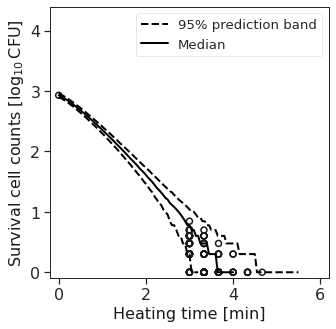

In [ ]:

#graph
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Heating time [min]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.2,6.2)
plt.ylim(-0.1,4.4)
plt.xticks([0,2,4,6])
plt.scatter(0,np.log10(N0),zorder=2,facecolors='none', edgecolors='k',lw=1.5)
plt.scatter(time,np.log10(N), zorder=2, facecolors ='none',edgecolors='k',linewidth=1.5)

#prediction interval
plt.plot(T,y_pred_025, linestyle = 'dashed', zorder=2, color='black', lw=2.0, label='95% prediction band')
plt.plot(T,y_pred_975, linestyle = 'dashed', zorder=2, color='black', lw=2.0)
plt.plot(T,y_pred_500, linestyle = 'solid', zorder=2, color='black', lw=2.0, label='Median')

plt.legend()
plt.show()